# LSTM com Tensorflow 
### Objetivo Geral: Previsão do parâmetro Wet Bulb da base de dados QCLCD_PDX_20150901 utilizando ele mesmo como parâmetro previsor.
### Objetivos Específicos: garregar e processar dados, tratar a base para previsão, implementar algoritmo LSTM para Tensorflow, validar e avaliar resultados.
#### Autor: Leonardo Bonifácio

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## 1. Carregamento e processamento de dados

A base utilizada contém 807 registros e mostra, de hora em hora, diversos(44) parâmetros metereológicos utlizados na aviação para melhor controle e segurança de uma aeronave.

In [2]:
df = pd.read_csv('QCLCD_PDX_20150901 - Copy.csv')
print(len(df))
df.head(5)

807


,WBAN,Date,Time,StationType,SkyCondition,SkyConditionFlag,Visibility,VisibilityFlag,WeatherType,WeatherTypeFlag,...,PressureChange,PressureChangeFlag,SeaLevelPressure,SeaLevelPressureFlag,RecordType,RecordTypeFlag,HourlyPrecip,HourlyPrecipFlag,Altimeter,AltimeterFlag
0,24229,20150901,53,11,OVC060,,10.0,,,,...,,,29.95,,AA,,,,29.96,NaN
1,24229,20150901,153,11,OVC060,,10.0,,,,...,,,29.94,,AA,,,,29.95,NaN
2,24229,20150901,253,11,OVC055,,10.0,,,,...,,,29.94,,AA,,,,29.95,NaN
3,24229,20150901,353,11,OVC055,,10.0,,,,...,,,29.94,,AA,,,,29.95,NaN
4,24229,20150901,453,11,OVC060,,10.0,,,,...,,,29.94,,AA,,,,29.95,NaN


Foi utilizado um parâmetros previsor, *WetBulbCelsius*, para prever *WetBulbCelsius*. Esse parâmetro informa a temperatura, em graus Celsius, de um sensor de temperatura utilizado na aviação.

In [3]:
dataset = df.filter(items = ['WetBulbCelsius'])
dataset.dropna()
dataset.head(5)

,WetBulbCelsius
0,14.6
1,14.9
2,14.9
3,14.6
4,14.4


In [4]:
dataset.describe()

,WetBulbCelsius
count,807.000000
mean,13.470136
std,2.652769
min,6.900000
25%,11.500000
50%,13.400000
75%,15.200000
max,21.000000


#### Visualização gráfica da série temporal para esse parâmetro

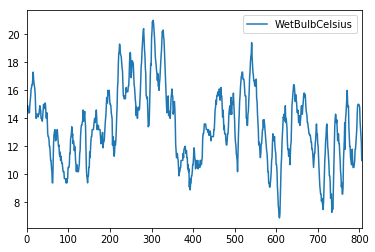

In [5]:
dataset.plot()

--------

## 2. Tratar base para previsão
Para obter o valor do próximo dado, 30 registros anteriores são usados. É necessário separar o *dataset* em treinamento e teste e, em seguida, separar cada pedaço (*batch*) dessas bases que serão usados nesses processos.

In [6]:
timesteps = 30

 #### Normalização da base de treinamento
 A normalização da base acelera o processo de treinamento, além de amenizar resultados insatisfatórios que podem ocorrer devido à grande variação nos valores durante o treinamento.


In [7]:
base = dataset.iloc[:][:].values # Conversão para float
normalizador = MinMaxScaler(feature_range=(0,1))

base_normalizada = normalizador.fit_transform(base)

Processo semelhante à matrização do keras para separar previsores da resposta real e criação de *batches* para treinamento e teste.

In [8]:
X = base_normalizada[0:(len(base) - (len(base) % timesteps))] # Previsores
X_batches = X.reshape(-1, timesteps, 1) # Batches com tamanho = timesteps. Quantidade = (total de registros / timesteps)

Y = base_normalizada[1:(len(base) - (len(base) % timesteps)) + 1] # Valores reais
y_batches = Y.reshape(-1, timesteps, 1)

 #### Criação e normalização das bases de testes


In [9]:
X_teste = base[-(timesteps + 1):] # Últimos registros do banco. (len(banco) - timesteps) até o final dele
X_teste = X_teste[:timesteps]
X_teste = normalizador.transform(X_teste)
X_teste = X_teste.reshape(-1, timesteps, 1) # Reshape para input do tensorflow

y_teste = base[-(timesteps):] # Reparar que o y_teste não utiliza a base normalizada
y_teste = y_teste.reshape(-1, timesteps, 1)

## 3. Algoritmo LSTM

In [10]:
tf.reset_default_graph() # Reseta o grafo atual

In [11]:
# Número de nós em cada camada
n_input = 1
n_hidden = 100
n_output = 1

In [12]:
# Criação dos placeholders
x = tf.placeholder(tf.float32, [None, timesteps, n_input])
y = tf.placeholder(tf.float32, [None, timesteps, n_output])

In [13]:
# Função para criar uma célula LSTM
def inicializarUmaCelula():
    return tf.contrib.rnn.LSTMCell(num_units = n_hidden, activation = tf.nn.relu)

Foram criadas 3 celúlas LSTM com Dropout. O uso de mais de uma célula pode melhorar os resultados. A camada de Dropout evita o *overfitting* do modelo.

In [14]:
# Função para criar n células LSTM
def inicializarVariasCelulas(n_celulas):
    celulas =  tf.nn.rnn_cell.MultiRNNCell([inicializarUmaCelula() for i in range(n_celulas)])
    return tf.contrib.rnn.DropoutWrapper(celulas, input_keep_prob = 0.9) # Dropout

In [15]:
# Criação das células
celula = inicializarVariasCelulas(3) # 3 células
celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size = 1)

#### Erros e métricas:
O otimizador mais adequado, depois de vários testes, foi o Adam com *learning rate* = 0.001. Para outros casos, o modelo não convergia muito bem ou treinava muito lentamente. A função de erro escolhida foi a MSE.

In [16]:
saida_rnn, _ = tf.nn.dynamic_rnn(celula, x, dtype = tf.float32)
erro = tf.losses.mean_squared_error(labels = y, predictions = saida_rnn)
otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)
treinamento = otimizador.minimize(erro)

In [17]:
init = tf.global_variables_initializer() # Inicializando variáveis globais

In [18]:
epocas = 1000
n_display = epocas/10

Sessão de treinamento:

In [19]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoca in range(epocas+1):
        _, custo = sess.run([treinamento, erro], feed_dict = {x: X_batches, y: y_batches})
        if epoca % n_display == 0:
            print('Epoca:', epoca, '\terro (MSE):', custo)
    
    previsoes = sess.run(saida_rnn, feed_dict = {x: X_teste})

Epoca: 0 	erro (MSE): 0.25964323
Epoca: 100 	erro (MSE): 0.020010244
Epoca: 200 	erro (MSE): 0.0060709654
Epoca: 300 	erro (MSE): 0.0026993514
Epoca: 400 	erro (MSE): 0.0021134322
Epoca: 500 	erro (MSE): 0.001647995
Epoca: 600 	erro (MSE): 0.001636575
Epoca: 700 	erro (MSE): 0.0013860752
Epoca: 800 	erro (MSE): 0.001304553
Epoca: 900 	erro (MSE): 0.0011659313
Epoca: 1000 	erro (MSE): 0.0010237437


Repare que o erro é bem pequeno devido à normalização

## 4. Resultados

Como essas variáveis estão no *shape* do tensorflow (3 dimensões), é necessário usar o método ravel para mudar suas dimensões.

In [20]:
y_teste_normal = np.ravel(y_teste)
print(y_teste.shape)
print(y_teste_normal.shape)

(1, 30, 1)
(30,)


In [21]:
previsoes_normal = np.ravel(previsoes)
print(previsoes.shape)
print(previsoes_normal.shape)

(1, 30, 1)
(30,)


As previsões devem ser desnormalizadas para comparar com y_teste

In [22]:
previsoes_normal = previsoes_normal.reshape(-1,1) 
previsoes_normal = normalizador.inverse_transform(previsoes_normal)
previsoes_normal = np.squeeze(previsoes_normal) # Para melhor visualização no print

A métrica *Mean Absolute Error* informa a diferença do valor real com o valor previsto, que é bom para verificar a acurácia do modelo.

In [23]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste_normal, previsoes_normal)

In [24]:
def exibirResultados():
    for i in range(len(previsoes_normal)):
        print('Previsão:', previsoes_normal[i], '\tValor real:', y_teste_normal[i])
    print()
    print('Mean Absolute Error:', round(mae,4))    

A função exibe um resumo dos resultados obtidos

In [25]:
exibirResultados()

Previsão: 12.682282 	Valor real: 12.0
Previsão: 12.05286 	Valor real: 12.0
Previsão: 11.605865 	Valor real: 11.2
Previsão: 10.891428 	Valor real: 11.0
Previsão: 10.514994 	Valor real: 10.7
Previsão: 10.343707 	Valor real: 10.7
Previsão: 10.524614 	Valor real: 11.8
Previsão: 12.120553 	Valor real: 11.0
Previsão: 11.667445 	Valor real: 10.5
Previsão: 10.822802 	Valor real: 10.5
Previsão: 10.68098 	Valor real: 10.5
Previsão: 10.750976 	Valor real: 10.7
Previsão: 10.879749 	Valor real: 11.0
Previsão: 11.132914 	Valor real: 11.8
Previsão: 11.977469 	Valor real: 11.8
Previsão: 12.2287445 	Valor real: 12.3
Previsão: 12.710534 	Valor real: 12.8
Previsão: 13.31516 	Valor real: 13.2
Previsão: 13.732882 	Valor real: 14.2
Previsão: 14.588444 	Valor real: 14.9
Previsão: 15.184147 	Valor real: 15.0
Previsão: 15.030798 	Valor real: 15.0
Previsão: 14.722762 	Valor real: 15.0
Previsão: 14.498985 	Valor real: 14.9
Previsão: 14.207388 	Valor real: 14.8
Previsão: 13.932244 	Valor real: 13.8
Previsão: 12.9

### Visualização do gráfico

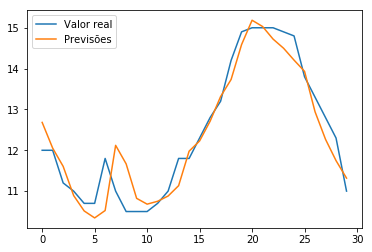

In [26]:
plt.plot(y_teste_normal, label = 'Valor real')
plt.plot(previsoes_normal, label = 'Previsões')
plt.legend()

Como há pouca variação nos valores, a escala do gráfico é bem pequena, o que causa a impressão de que a performance do modelo não foi muito boa. Porém, visualizando cada registro com sua previsão, vê-se que o modelo é satisfatório.

### Conclusão
O algortimo LSTM é usado, entre outras coisas, para realizar previsões em séries temporais. Sua estrutura permite criar uma memória de longo-prazo de forma eficiente. O objetivo desse trabalho foi prever um parâmetro utilizado na aviação utilizando ele mesmo como previsor. Tal objetivo foi alcançado com um algoritmo LSTM com o *framework* Tensorflow. A média do erro absoluto do modelo, validado com a base de teste, foi satisfatória (0.37). O gráfico exibe os resultados de forma mais visual, comprovando a performance do modelo e resultado satisfatório.

## Referências

[1] Mandic, D. P., & Chambers, J. A. (2001). Recurrent neural networks for prediction : learning algorithms, architectures, and stability. John Wiley. Retrieved from https://www.wiley.com/en-us/Recurrent+Neural+Networks+for+Prediction%3A+Learning+Algorithms%2C+Architectures+and+Stability-p-9780471495178

[2] Hoffman, G. (2018). Introduction to LSTMs with TensorFlow - O’Reilly Media. Retrieved February 23, 2019, from https://www.oreilly.com/ideas/introduction-to-lstms-with-tensorflow

[3] Yan, S. (2016). Understanding LSTM and its diagrams – ML Review – Medium. Retrieved February 23, 2019, from https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714